- Input: content image, style image.
- Goal: use neural networks to modify the content image to make it close to the style image in style.
- Method: CNN-based style transfer.

In [ ]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F 

from torchvision import transforms 
from torchvision.io import read_image 
from torch.utils.data import Dataset, DataLoader

from torchvision.models import vgg19, VGG19_Weights

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import os 
import copy 
import random 
from tqdm import tqdm 

%matplotlib inline 

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} device.')

Using cuda device.


In [ ]:
os.chdir('/content/drive/MyDrive/DL/Neural Style Transfer')

In [ ]:
!ls         # list directory

 Chapter8.ipynb			        NST.ipynb
 content_images			        style_images
'Copy of neural_style_tutorial.ipynb'   Untitled0.ipynb
 neural_style_transfer.ipynb


In [ ]:
!pwd        # get current directory 

/content/drive/MyDrive/DL/Neural Style Transfer


# Input images

In [ ]:
data_dir = '/content/drive/MyDrive/DL/Neural Style Transfer'
content_dir = os.path.join(data_dir, 'content_images')       # directory of content images
style_dir = os.path.join(data_dir, 'style_images')           # directory of style images 

torch.Size([3, 720, 811])
torch.Size([3, 560, 388])


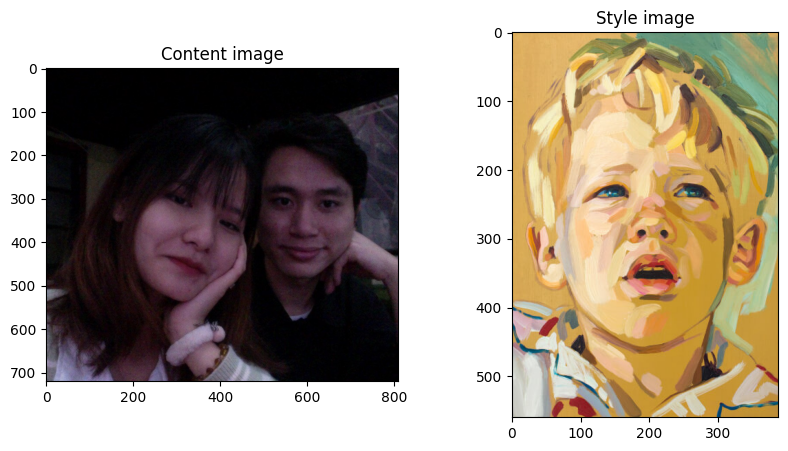

In [ ]:
mode = torchvision.io.image.ImageReadMode.RGB    # read RGB image 

content_img = read_image(os.path.join(content_dir, 'couple.jpg'))
style_img = read_image(os.path.join(style_dir, 'paint10.jpg'))

print(content_img.shape)
print(style_img.shape)

fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.imshow(content_img.permute(1, 2, 0))
plt.title('Content image')

fig.add_subplot(1, 2, 2)
plt.imshow(style_img.permute(1, 2, 0))
plt.title('Style image')
plt.show()

# Data processing

In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
rgb_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
crop_size = (800, 800)

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(crop_size), 
        transforms.ToTensor()                                 # convert pixel values to the range [0, 1]
    ])

def preprocess(img): 
    """Transforms the results into the CNN input format.
    """
    
    return transform(img).unsqueeze(0).to(device)                   # create the batch_size dimension 

def postprocess(img): 
    """Restore the pixel values in the output image to their original values.
    """

    img = img.cpu().clone() 
    img = img.squeeze(0)                                 # select the batch_size dimension 
    img = torch.clamp(img, 0, 1)                         # reshape to match the dimension 2 

    return img                                   

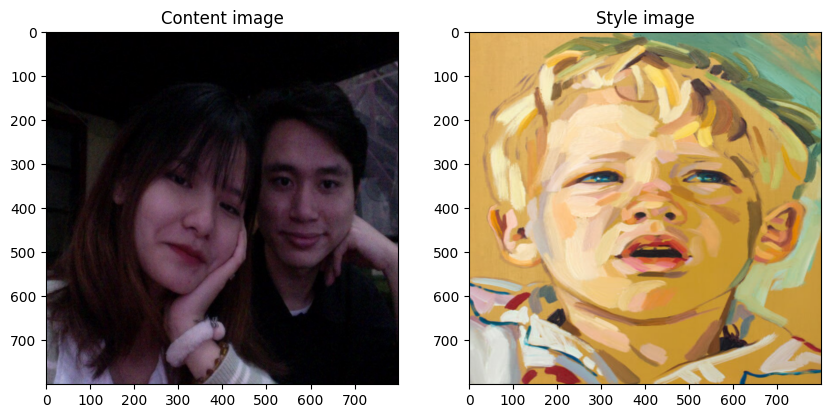

In [ ]:
style_img = preprocess(style_img)
content_img = preprocess(content_img)

fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.imshow(content_img.cpu().squeeze(0).permute(1, 2, 0))
plt.title('Content image')

fig.add_subplot(1, 2, 2)
plt.imshow(style_img.cpu().squeeze(0).permute(1, 2, 0))
plt.title('Style image')
plt.show()

# Define model and losses 

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: 
- ``features``: containing convolution and pooling layers.
- ``classifier``: containing fully connected layers.

We will use the ``features`` module because we need the output of the individual
convolution layers to measure content and style loss

- Select the output of certain layers in the VGG network to extract the *content features* and *style features* of the image.
- The closer to the input layer, the easier to extract details of the image, and vice versa, the easier to extract the global
information of the image. 

In [ ]:
pretrained_net = vgg19(weights=VGG19_Weights.DEFAULT).eval()
print(pretrained_net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
def gram_matrix(X): 
    """Convert a style output X (feature maps) of shape (bs, c, h, w) 
    to Gram matrix and standardize its elements.    
    """

    bs, c, h, w = X.shape             
    num_els = X.numel()           

    X = X.view(bs * c, h * w)
    gram = torch.matmul(X, X.T)                 # compute Gram matrix 

    return gram / num_els                       # standardize the Gram matrix by dividing by its element 

In [ ]:
class StyleLoss(nn.Module):
    """Compute style loss between synthesized image and style image squared loss function.
    """

    def __init__(self, style):
        super(StyleLoss, self).__init__()
        
        # Compute gram matrix of style features 
        self.gram = gram_matrix(style).detach()

    def forward(self, syn_style):
        """Compute MSE loss. 
        """

        self.loss = torch.square(gram_matrix(syn_style) - self.gram).mean()       # or F.mse_loss()

        return syn_style

In [ ]:
class ContentLoss(nn.Module): 
    """Measure the difference in content features between synthesized image 
    and the content image via squared loss function.
    """

    def __init__(self, content): 
        super(ContentLoss, self).__init__()
        
        # detach the target content (Y) from the tree used to dynamically compute the gradient: 
        # this is a stated value, not a variable. Otherwise the loss will throw an error.
        self.content = content.detach()

    def forward(self, syn_content): 
        """Compute MSE loss.
        """

        self.loss = torch.square(syn_content - self.content).mean()      # or F.mse_loss(syn_content, self.content)

        return syn_content

In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
rgb_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    """A module to normalize input image so we can easily put it in a nn.Sequential.
    """

    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W]
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        """Normalize image.
        """

        return (img - self.mean) / self.std

In [ ]:
for layer in pretrained_net.features[:5]: 
    print(layer.__class__.__name__)

Conv2d
ReLU
Conv2d
ReLU
MaxPool2d


In [ ]:
pretrained_model = pretrained_net.features.to(device)

In [ ]:
# desired depth layers to compute style/content losses
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def define_model_and_losses(pretrained_model, style_img, content_img, content_layers, style_layers):

    # normalization module
    normalization = Normalization(rgb_mean, rgb_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0                                       # increment every time we see a conv
    for layer in pretrained_model.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)           # define content loss 
            model.add_module(f"Content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)       # define style loss 
            model.add_module(f"Style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    model.requires_grad_(False)

    return model, style_losses, content_losses

In [ ]:
model, style_losses, content_losses = define_model_and_losses(pretrained_model, 
                                                           style_img, 
                                                           content_img, 
                                                           content_layers, 
                                                           style_layers)

<ipython-input-56-861b11c6d526>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-56-861b11c6d526>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


<!-- ## Total variational loss  -->

# Init and model config

In style transfer, the synthesized image is the only variable that needs to be updated during
training.

In [ ]:
# initialize the synthesized image to be the content image 
syn_img = content_img.clone()

num_epochs = 300

In [ ]:
def get_input_optimizer(syn_img):

    optimizer = torch.optim.LBFGS([syn_img])
    
    return optimizer

# Training

When training the model for style transfer, we continuously extract content features and style
features of the synthesized image, and calculate the loss function.

In [ ]:
weights = {
    'content': 1,
    'style': 1e6
}

def style_transfer(model, content_img, style_img, syn_img, 
                   epochs, weights):
    """Run the style transfer. 
    """

    model, style_losses, content_losses = define_model_and_losses(pretrained_model, 
                                                           style_img, 
                                                           content_img, 
                                                           content_layers, 
                                                           style_layers)
    
    syn_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(syn_img)

    epoch = [0]
    while epoch[0] <= num_epochs:  

        def closure():
            with torch.no_grad():
                syn_img.clamp_(0, 1)

            optimizer.zero_grad()

            model(syn_img)

            style_loss = 0
            content_loss = 0

            for sl in style_losses:
                style_loss += sl.loss
            for cl in content_losses:
                content_loss += cl.loss

            style_loss *= weights['style']
            content_loss *= weights['content']

            loss = style_loss + content_loss
            loss.backward()

            epoch[0] += 1
            if epoch[0] % 50 == 0:
                print(f"Epoch {epoch[0]}: ")
                print(f'Style Loss : {style_loss.item():4f} Content Loss: {content_loss.item():4f}')
                print()

            return style_loss + content_loss

        optimizer.step(closure)            # run the closure function 

    with torch.no_grad():
        syn_img.clamp_(0, 1)

    return syn_img

# Print output

In [ ]:
output = style_transfer(model, content_img, style_img, syn_img, 
                        num_epochs, weights)

<ipython-input-56-861b11c6d526>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-56-861b11c6d526>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch 50: 
Style Loss : 298.989624 Content Loss: 8.436227

Epoch 100: 
Style Loss : 92.631218 Content Loss: 9.519821

Epoch 150: 
Style Loss : 19.084208 Content Loss: 8.873753

Epoch 200: 
Style Loss : 6.443114 Content Loss: 7.660800

Epoch 250: 
Style Loss : 4.476275 Content Loss: 6.715763

Epoch 300: 
Style Loss : 3.365602 Content Loss: 6.299345



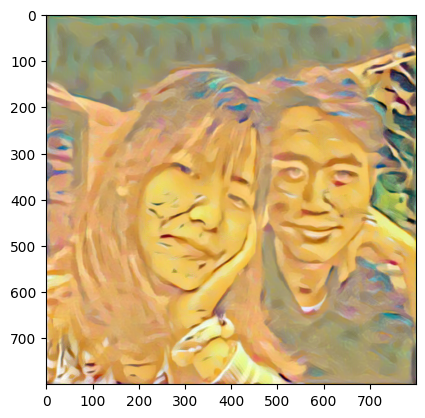

In [ ]:
plt.figure()
output = postprocess(output)
plt.imshow(output.detach().permute(1, 2, 0))
plt.show()